# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [20]:
# import libraries here; add more as necessary
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.utils import resample
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
pd. set_option('display.max_rows', 500)

In [4]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [5]:
azdias.shape

(891221, 366)

In [6]:
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [7]:
customers.shape

(191652, 369)

# 1. Preprocessing

## 1.1 Analyse Attribute Values

In the attributes_values dataframe you can see that unknown values are represented by one or more multiple values. at first I want to treat those values as nan.

In [8]:
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)
attributes_values = attributes_values[attributes_values.columns[1:]]
attributes_values = attributes_values[attributes_values['Attribute'].notnull()]

In [9]:
attributes_values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
11,ALTER_HH,main age within the household,0,unknown / no main age detectable
33,ANREDE_KZ,gender,"-1, 0",unknown
36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10)


In [10]:
set(attributes_values['Meaning'].tolist())

{'Event travelers',
 'Universal',
 'Work-Life-Balance',
 'building is located in a 125 x 125m-grid cell (RA1), which is a consumption cell',
 'business cell',
 "doesn't belong to the green avantgarde",
 'highest activity within the last 12 months',
 'low-income earners',
 'mainly 1-2 family homes',
 'no Online-transactions within the last 12 months',
 'no transaction known',
 'no transactions known',
 'none',
 'numeric value',
 'numeric value (typically coded from 1-10)',
 'numeric value (typically coded from 1-3)',
 'single ',
 'single low-income earners of younger age',
 'single low-income- and average earners of younger age ',
 'typical low-income earners',
 'unknown',
 'unknown / no main age detectable',
 'very high mobility',
 'very low',
 'very low car quote'}

In [11]:
unknown = attributes_values[attributes_values['Meaning'].isin(['unknown', 'unknown / no main age detectable'])]
set(unknown['Meaning'].tolist())

{'unknown', 'unknown / no main age detectable'}

In [12]:
for column in azdias.columns:
    if azdias[column].dtype == np.int64:
        azdias[column] = azdias[column].astype(np.float64)
    if column not in set(unknown['Attribute']):
        continue
        
    unknown_value = unknown.loc[unknown['Attribute'] == column].Value.item()
    unknown_value = set(float(x) for x in unknown_value.split(', ')) if type(unknown_value) is str else set([float(unknown_value)])
    azdias[column] = azdias[column].mask(azdias[column].isin(unknown_value), other=np.nan)

In [13]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220.0,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225.0,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226.0,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241.0,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


## 1.2 Missing Values
Now I want to take a look at the missing values to decide wich feature I can drop because of lack of information.

Text(0.5, 1.0, 'Proportion of missing values in AZDIAS features')

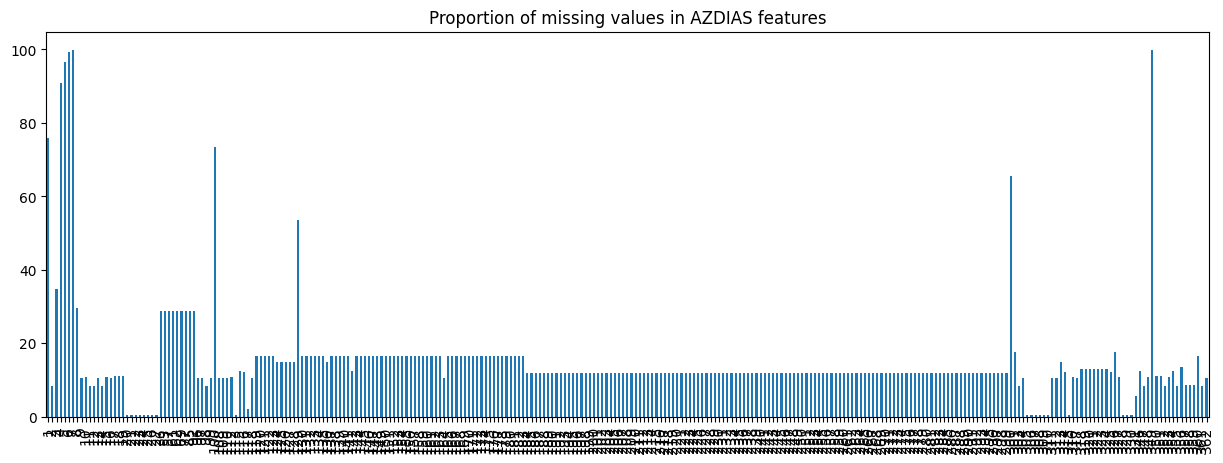

In [14]:
#visualize all feature with nan values
az = azdias.isna().sum().reset_index()
az.columns = ['feature', 'missing_value_count']
az = az[az['missing_value_count']!=0]
az['per'] = az['missing_value_count']/azdias.shape[0]*100
az[['feature','per']].plot(kind='bar',legend=False, figsize=(15,5))
plt.title('Proportion of missing values in AZDIAS features')
#az[az['feature','per']].plot(kind='bar')
#az['O'].name = 'missing_values_count'

In [15]:
#all features with high share of nan values
az[az['per']>=40]

,feature,missing_value_count,per
1,AGER_TYP,677503,76.019640
4,ALTER_KIND1,810163,90.904837
5,ALTER_KIND2,861722,96.690047
6,ALTER_KIND3,885051,99.307691
7,ALTER_KIND4,890016,99.864792
100,EXTSEL992,654153,73.399639
129,KBA05_BAUMAX,476524,53.468668
300,KK_KUNDENTYP,584612,65.596749
349,TITEL_KZ,889061,99.757636


- There are 9 features having more than 40% missing values

<AxesSubplot:>

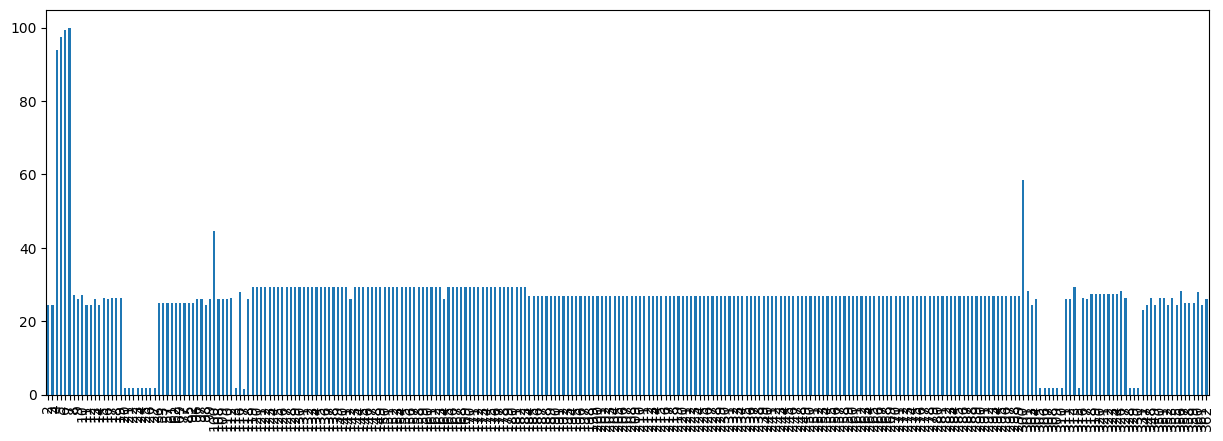

In [16]:
#visualize all feature with nan values
cu = customers.isna().sum().reset_index()
cu.columns = ['feature', 'missing_value_count']
cu = cu[cu['missing_value_count']!=0]
cu['per'] = cu['missing_value_count']/customers.shape[0]*100
cu[['feature','per']].plot(kind='bar',legend=False, figsize=(15,5))


In [17]:
#all features with high share of nan values
cu[cu['per']>=40]

,feature,missing_value_count,per
4,ALTER_KIND1,179886,93.860748
5,ALTER_KIND2,186552,97.338927
6,ALTER_KIND3,190377,99.334732
7,ALTER_KIND4,191416,99.876860
100,EXTSEL992,85283,44.498883
300,KK_KUNDENTYP,111937,58.406382


## 1.3 Threshold for columns to drop
Now I want to define a threshold for columns to drop. I did that with the help of the 99% confidence interval to get as many columns as possible.

In [18]:
median = az['per'].median()
mean = az['per'].mean()

import scipy.stats as st
conf = st.t.interval(alpha=0.9999, df=len(az['per'])-1, loc=np.mean(az['per']), scale=st.sem(az['per']))

print('median: '+str(median))
print('mean :'+str(mean))
print('1%-Conf.- Int. :'+str(conf[0]))
print('99%-Conf.- Int. :'+str(conf[1]))

median: 11.871354018812394
mean :14.909498792038189
1%-Conf.- Int. :11.611334352119977
99%-Conf.- Int. :18.207663231956403


Text(0.5, 1.0, 'Proportion of missing values in AZDIAS features')

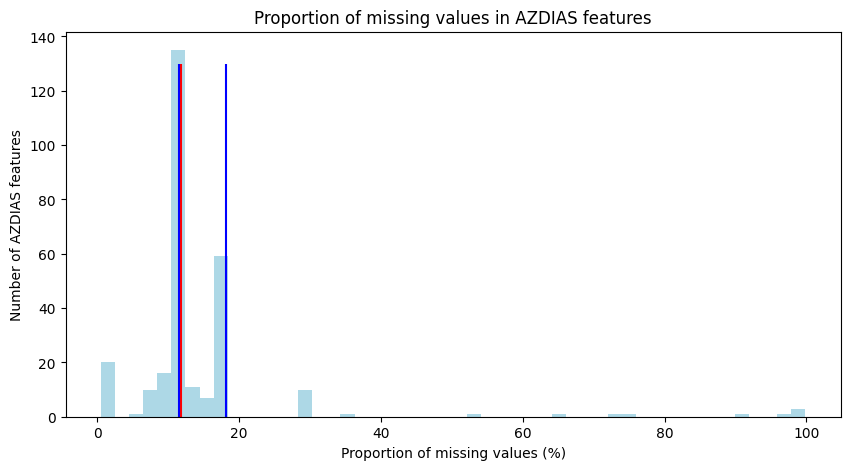

In [19]:
plt.figure(figsize=(10,5))
plt.hist(az['per'],bins=50, color='lightblue')
plt.vlines(x=median, ymin=0, ymax=130, color='red');
plt.vlines(x=conf[0], ymin=0, ymax=130, color='blue');
plt.vlines(x=conf[1], ymin=0, ymax=130, color='blue')
plt.xlabel('Proportion of missing values (%)')
plt.ylabel('Number of AZDIAS features')
plt.title('Proportion of missing values in AZDIAS features')

- You can see that 99% features have less than 20% missing values.
- So that is a good threshold to use.

In [20]:
#azdias
columns_to_drop = az[az['per'] > 20]
columns_to_drop = columns_to_drop['feature'].tolist()

In [21]:
#create a list of columns to drop
columns_to_drop

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_SOZIALES',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ONLINE_QUOTE_12',
 'EXTSEL992',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [22]:
azdias.drop(labels=columns_to_drop, axis=1, inplace=True)

In [23]:
azdias.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220.0,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225.0,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241.0,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


## 1.4 Threshold for rows to drop
Now I did the same for rows to drop

In [24]:
#missing row values percentage
missing_row = azdias.isnull().sum(axis=1)/azdias.shape[1]*100
#missing_row

In [25]:
import scipy.stats as st
conf_row = st.t.interval(alpha=0.99, df=len(missing_row)-1, loc=np.mean(missing_row), scale=st.sem(missing_row))
conf_row[1]

8.962019702938353

Text(0.5, 1.0, 'Proportion of missing values')

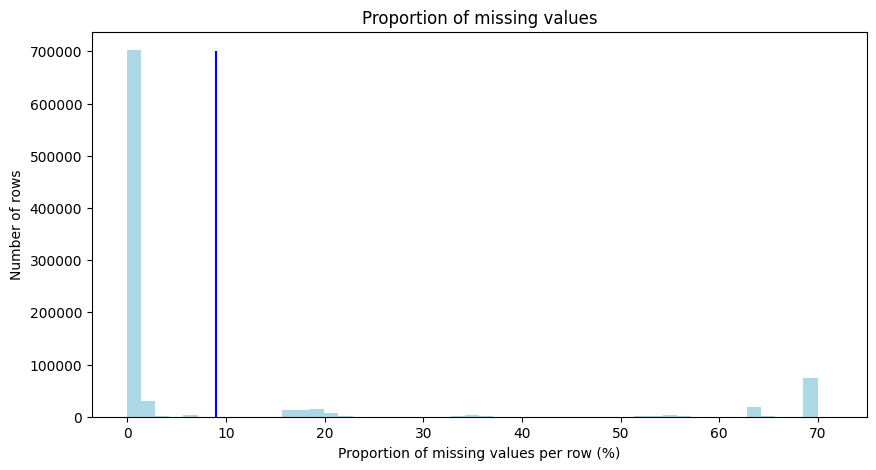

In [26]:
plt.figure(figsize=(10,5))
plt.hist(missing_row,bins=50, color='lightblue')
#plt.vlines(x=median, ymin=0, ymax=130, color='red');
#plt.vlines(x=conf[0], ymin=0, ymax=130, color='blue');
plt.vlines(x=conf_row[1], ymin=0, ymax=700000, color='blue')
plt.xlabel('Proportion of missing values per row (%)')
plt.ylabel('Number of rows')
plt.title('Proportion of missing values')

- You can see that 99% features have less than 10% missing values.
- So that is a good threshold to use.

In [27]:
azdias = azdias[missing_row <= 10]
azdias.shape

(737287, 346)

## 1.5 Reencoding
To use the data for the segmentation and a prediciton model I need to understand which features are categorial and which features I might need to reencode. I need to get all features as float or one hot encoded.

In [28]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

In [29]:
azdias.dtypes

LNR                            float64
AKT_DAT_KL                     float64
ANZ_HAUSHALTE_AKTIV            float64
ANZ_HH_TITEL                   float64
ANZ_KINDER                     float64
ANZ_PERSONEN                   float64
ANZ_STATISTISCHE_HAUSHALTE     float64
ANZ_TITEL                      float64
ARBEIT                         float64
BALLRAUM                       float64
CAMEO_DEU_2015                  object
CAMEO_DEUG_2015                 object
CAMEO_INTL_2015                 object
CJT_GESAMTTYP                  float64
CJT_KATALOGNUTZER              float64
CJT_TYP_1                      float64
CJT_TYP_2                      float64
CJT_TYP_3                      float64
CJT_TYP_4                      float64
CJT_TYP_5                      float64
CJT_TYP_6                      float64
D19_BANKEN_ANZ_12              float64
D19_BANKEN_ANZ_24              float64
D19_BANKEN_DATUM               float64
D19_BANKEN_DIREKT              float64
D19_BANKEN_GROSS         

In [30]:
# feature with object type
azdias_object_cols = azdias.columns[azdias.dtypes == "object"].tolist()
azdias_object_cols

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'EINGEFUEGT_AM',
 'OST_WEST_KZ']

In [31]:
# azdias['EINGEFUEGT_AM'] not part of attributes values - possible timestamp of data put into database
# possible column to drop

In [32]:
azdias.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)

In [33]:
#looking into feature values that are not correct
print(azdias['CAMEO_DEUG_2015'].value_counts())
print(azdias['CAMEO_INTL_2015'].value_counts())
print(azdias['CAMEO_DEU_2015'].value_counts())

8      74754
6      58203
9      57473
4      55290
8.0    54106
2      44419
3      44192
6.0    42489
9.0    41978
7      41861
4.0    40292
2.0    32192
3.0    32129
7.0    30622
5      28976
5.0    20737
1      19840
1.0    14394
X        284
Name: CAMEO_DEUG_2015, dtype: int64
51      73261
51.0    53068
41      50263
24      49091
41.0    36549
24.0    35513
14      33995
43      31172
54      24641
14.0    24480
43.0    22834
25      21392
54.0    18064
22      17423
25.0    15789
45      14548
13      14004
22.0    12831
55      11814
23      11576
52      11561
45.0    10473
13.0    10205
34      10026
15       9389
31       9329
55.0     8702
52.0     8496
23.0     8288
44       7982
34.0     7286
12       6871
15.0     6851
31.0     6808
44.0     5886
35       5685
32       5674
33       5311
12.0     5050
32.0     4017
35.0     4010
33.0     3739
XX        284
Name: CAMEO_INTL_2015, dtype: int64
6B    54006
8A    50776
4C    43988
2D    32906
7A    32629
3C    32565
3D    3

In [34]:
# change 'X'  and 'xx' to nan
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('X', np.nan)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace('XX', np.nan)
azdias['CAMEO_DEU_2015'] = azdias['CAMEO_DEU_2015'].replace('XX', np.nan)

# change str to float
azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].astype(float)
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)

In [35]:
azdias.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220.0,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225.0,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241.0,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0
5,910244.0,1.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4.0,2.0,1.0


In [36]:
#create columns to encode list
columns_to_encode = azdias.columns[azdias.dtypes == "object"].tolist()
columns_to_encode

['CAMEO_DEU_2015', 'OST_WEST_KZ']

In [37]:
#create df with features to encode
encode = azdias[columns_to_encode]
encode

,CAMEO_DEU_2015,OST_WEST_KZ
1,8A,W
2,4C,W
3,2A,W
4,6B,W
5,8C,W
...,...,...
891216,7A,W
891217,9D,W
891218,4C,W
891219,9D,W


In [38]:
 encode = encode.fillna('0')

In [39]:
#encode features with one hot encoder
feature_array = ohe.fit_transform(encode).toarray()
feature_labels = ohe.categories_
feature_labels = np.hstack(feature_labels)

In [40]:
#add labels to feature array and convert to dataframe
features = pd.DataFrame(feature_array, columns=feature_labels)


In [41]:
features.columns

Index(['0', '1A', '1B', '1C', '1D', '1E', '2A', '2B', '2C', '2D', '3A', '3B',
       '3C', '3D', '4A', '4B', '4C', '4D', '4E', '5A', '5B', '5C', '5D', '5E',
       '5F', '6A', '6B', '6C', '6D', '6E', '6F', '7A', '7B', '7C', '7D', '7E',
       '8A', '8B', '8C', '8D', '9A', '9B', '9C', '9D', '9E', 'O', 'W'],
      dtype='object')

In [42]:
features.drop(labels='0', axis=1, inplace=True)

In [43]:
#drop nan column
features.drop(features.columns[-3], axis=1, inplace=True)

In [44]:
features.head()

,1A,1B,1C,1D,1E,2A,2B,2C,2D,3A,...,8A,8B,8C,8D,9A,9B,9C,9D,O,W
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [45]:
#drop columns to encode from azdias
azdias = azdias.drop(labels=columns_to_encode,  axis=1)

In [46]:
#add one hot encoded features to azdias
azdias = azdias.reset_index().drop(labels='index',  axis=1)


In [48]:
azdias = pd.concat([azdias, features], axis=1, ignore_index=False)

In [49]:
azdias.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,8A,8B,8C,8D,9A,9B,9C,9D,O,W
0,910220.0,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,910225.0,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,910226.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,910241.0,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,910244.0,1.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 1.6 Clean customer with Data Cleaning Function
Now I wrote a cleaning function to clean customer data set in the same way as azdias.

In [50]:
def clean_data(df, attributes_values, columns_to_drop, nan_threshold):
    """
    Clean and prerpocess a dataframe
    - convert missing and unknown values to nan values
    - drop columns (features) with high %nan vlaues
    - drop rows with high %nan vlaues
    - re-encode categorical and mixed features
    - impute missing values
    
    INPUT
    - df (DataFrame): the DataFrame to be cleaned and preprocessed
    - attributes_values (DataFrame): the DataFrame to find unknown values for each feature
    - columns_to_drop (list): list of features to be droped due to high %nan values
    - nan_threshold (int): threshold to use for dropping rows having high %nan values
    
    OUTPUT
    - df_imputed (DataFrame): a cleaned and preprocessed DataFrame with nan values imputed
    """
    # convert missing and unknown values to nan values
    attributes_values = attributes_values[attributes_values.columns[1:]]
    attributes_values = attributes_values[attributes_values['Attribute'].notnull()]
    unknown = attributes_values[attributes_values['Meaning'].isin(['unknown', 'unknown / no main age detectable'])]

    for column in df.columns:
        if df[column].dtype == np.int64:
            df[column] = df[column].astype(np.float64)
        if column not in set(unknown['Attribute']):
            continue
        
        unknown_value = unknown.loc[unknown['Attribute'] == column].Value.item()
        unknown_value = set(float(x) for x in unknown_value.split(', ')) if type(unknown_value) is str else set([float(unknown_value)])
        df[column] = df[column].mask(df[column].isin(unknown_value), other=np.nan)
    
    
    
    # drop columns (features) with %nan values over a threshold
    df.drop(labels=columns_to_drop, axis=1, inplace=True)

    # drop rows with %missing values over a threshold
    missing_row = azdias.isnull().sum(axis=1)/azdias.shape[1]*100
    df = df[missing_row <= nan_threshold]

    # RE-ENCODE FEATURES #
    
    #drop database timestamp
    df.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)
    
    # change 'X'  and 'xx' to nan
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan)
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX', np.nan)

    # change str to float
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    
    #import sklearn one hot encoder
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder()
    
    #create columns to encode list
    columns_to_encode = df.columns[df.dtypes == "object"].tolist()
    
    #create df with features to encode
    encode = df[columns_to_encode]
    encode = encode.fillna('0')
    
    #encode features with one hot encoder
    feature_array = ohe.fit_transform(encode).toarray()
    feature_labels = ohe.categories_
    feature_labels = np.hstack(feature_labels)
    
    #add labels to feature array and convert to dataframe
    features = pd.DataFrame(feature_array, columns=feature_labels)
    #drop nan column
    features.drop(labels='0', axis=1, inplace=True)
    
    #drop columns to encode from azdias
    df = df.drop(labels=columns_to_encode,  axis=1)
    
    #add one hot encoded features to azdias
    df = df.reset_index().drop(labels='index',  axis=1)
    df = pd.concat([df, features], axis=1, ignore_index=False)
    
    # impute missing values
    #from sklearn.impute import SimpleImputer
    #imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    #df_imputed = pd.DataFrame(imputer.fit_transform(df))
    #df_imputed = df
    return df

In [51]:
#drop additional columns
customers.drop(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'], axis=1, inplace=True)

In [52]:
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)

In [53]:
customers = clean_data(customers, attributes_values, columns_to_drop, 10)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [55]:
#check for feature differences
set(list(customers.columns.values)) - set(list(azdias.columns.values))

{'9E'}

- you can see that caustomers have one more feature. I will add that feature with null values to azdias, because this will be a good feature for customer prediciton, because only customers have this feature to be 1.

In [56]:
#add column 9E to azdias
azdias["9E"] = 0
order = customers.columns.tolist()
azdias = azdias[order]
azdias.head()

,LNR,AKT_DAT_KL,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,8B,8C,8D,9A,9B,9C,9D,9E,O,W
0,910220.0,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0
1,910225.0,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0
2,910226.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0
3,910241.0,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0
4,910244.0,1.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1.0


In [57]:
set(list(customers.columns.values)) - set(list(azdias.columns.values))

set()

## 1.6 Impute missing values
To use as many data as possible I decided to impute all missing values.

In [58]:
def impute_data(df):
    """
    - impute missing values
    
    INPUT
    - df (DataFrame): the clean DataFrame 
    
    OUTPUT
    - df_imputed (DataFrame): a DataFrame with nan values imputed
    """
    
    # impute missing values
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    df = pd.DataFrame(imputer.fit_transform(df))
    
    return df

In [59]:
azdias_imputed = impute_data(azdias)

In [60]:
azdias_imputed.head()

,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
0,910220.0,9.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,910225.0,9.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,910226.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,910241.0,1.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,910244.0,1.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [61]:
customers_imputed = impute_data(customers)

In [62]:
customers_imputed.head()

,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
0,9626.0,1.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,9628.0,9.0,1.0,0.0,0.0,3.0,1.0,0.0,3.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,143872.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,143873.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,143874.0,1.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## 1.7 Scale Features
 As Preperation for PCA  I scaled the features.

In [63]:
def scale_data(df):
    """
    - scale features
    
    INPUT
    - df (DataFrame): the clean and imputed DataFrame 
    
    OUTPUT
    - df (DataFrame): a DataFrame with scaled features
    """
    
    # scale features
    from sklearn.preprocessing import StandardScaler
    
    scaler = StandardScaler()
    df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    #df.to_pickle('azdias_scaled.pkl')
    
    return df

In [64]:
azdias_scaled = scale_data(azdias_imputed)
azdias_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
count,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,...,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,7.372870e+05,737287.0,7.372870e+05,7.372870e+05
mean,-3.065251e-17,8.169326e-17,2.734464e-17,-2.195278e-17,-5.248031e-17,-4.791526e-17,-5.632226e-18,-1.435154e-17,-9.772394e-17,5.861864e-17,...,-8.946089e-18,-1.807017e-17,-3.492935e-17,4.905065e-18,8.596738e-18,5.724232e-18,4.048613e-17,0.0,9.864941e-17,-9.864941e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,0.0,1.000001e+00,1.000001e+00
min,-1.730544e+00,-9.343317e-01,-5.411579e-01,-1.253033e-01,-2.990608e-01,-1.493626e+00,-5.459847e-01,-6.066053e-02,-2.190006e+00,-1.437978e+00,...,-2.104255e-01,-2.064759e-01,-1.521185e-01,-1.672260e-01,-1.907623e-01,-1.791170e-01,-1.940148e-01,0.0,-5.159335e-01,-1.938234e+00
25%,-8.632372e-01,-9.343317e-01,-4.087997e-01,-1.253033e-01,-2.990608e-01,-6.344692e-01,-4.725354e-01,-6.066053e-02,-1.784099e-01,-9.803702e-01,...,-2.104255e-01,-2.064759e-01,-1.521185e-01,-1.672260e-01,-1.907623e-01,-1.791170e-01,-1.940148e-01,0.0,-5.159335e-01,5.159335e-01
50%,-7.263976e-03,-3.851864e-01,-2.764415e-01,-1.253033e-01,-2.990608e-01,-6.344692e-01,-2.521877e-01,-6.066053e-02,-1.784099e-01,3.924520e-01,...,-2.104255e-01,-2.064759e-01,-1.521185e-01,-1.672260e-01,-1.907623e-01,-1.791170e-01,-1.940148e-01,0.0,-5.159335e-01,5.159335e-01
75%,8.714860e-01,1.262249e+00,5.445398e-02,-1.253033e-01,-2.990608e-01,2.246875e-01,1.150584e-01,-6.066053e-02,8.273883e-01,8.500594e-01,...,-2.104255e-01,-2.064759e-01,-1.521185e-01,-1.672260e-01,-1.907623e-01,-1.791170e-01,-1.940148e-01,0.0,-5.159335e-01,5.159335e-01
max,1.727560e+00,1.262249e+00,3.493084e+01,6.412654e+01,2.221387e+01,3.115433e+01,2.699748e+01,5.855561e+01,5.856379e+00,1.307667e+00,...,4.752276e+00,4.843180e+00,6.573820e+00,5.979932e+00,5.242125e+00,5.582943e+00,5.154246e+00,0.0,1.938234e+00,5.159335e-01


In [65]:
customers_scaled = scale_data(customers_imputed)
customers_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,379,380,381,382,383,384,385,386,387,388
count,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,...,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05,1.916520e+05
mean,1.186388e-18,-2.224478e-18,-1.683188e-17,-5.468508e-18,1.508938e-17,1.741025e-16,-1.253123e-17,2.398729e-17,-1.481502e-16,8.786688e-17,...,-3.820541e-17,5.449971e-18,3.223639e-17,3.433111e-17,4.982831e-17,-5.307234e-17,-4.515690e-17,2.500684e-17,-6.369422e-17,1.141899e-16
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,...,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-1.732042e+00,-3.250739e-01,-3.164432e-01,-1.052176e-01,-2.383791e-01,-1.812549e+00,-3.037014e-01,-1.162835e-01,-2.144783e+00,-1.889370e+00,...,-1.420366e-01,-1.217859e-01,-1.079096e-01,-7.325602e-02,-6.933771e-02,-7.194872e-02,-1.015705e-01,-8.905522e-02,-2.508160e-01,-1.458763e+00
25%,-8.660209e-01,-3.250739e-01,-2.359790e-01,-1.052176e-01,-2.383791e-01,-9.896773e-01,-2.224342e-01,-1.162835e-01,-9.984408e-01,-8.047012e-01,...,-1.420366e-01,-1.217859e-01,-1.079096e-01,-7.325602e-02,-6.933771e-02,-7.194872e-02,-1.015705e-01,-8.905522e-02,-2.508160e-01,-1.458763e+00
50%,0.000000e+00,-3.250739e-01,-2.359790e-01,-1.052176e-01,-2.383791e-01,-1.668053e-01,-2.224342e-01,-1.162835e-01,1.479014e-01,2.799679e-01,...,-1.420366e-01,-1.217859e-01,-1.079096e-01,-7.325602e-02,-6.933771e-02,-7.194872e-02,-1.015705e-01,-8.905522e-02,-2.508160e-01,6.855121e-01
75%,8.660209e-01,-3.250739e-01,-1.555148e-01,-1.052176e-01,-2.383791e-01,6.560666e-01,-1.411669e-01,-1.162835e-01,1.479014e-01,8.223025e-01,...,-1.420366e-01,-1.217859e-01,-1.079096e-01,-7.325602e-02,-6.933771e-02,-7.194872e-02,-1.015705e-01,-8.905522e-02,-2.508160e-01,6.855121e-01
max,1.732042e+00,4.271391e+00,4.176631e+01,4.919838e+01,1.823360e+01,1.546776e+01,3.017152e+01,3.755438e+01,7.025955e+00,1.364637e+00,...,7.040441e+00,8.211133e+00,9.267017e+00,1.365075e+01,1.442217e+01,1.389879e+01,9.845381e+00,1.122899e+01,3.986986e+00,6.855121e-01


In [66]:
azdias_scaled.to_pickle('azdias_scaled.pkl')
customers_scaled.to_pickle('customers_scaled.pkl')

In [67]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [21]:
azdias_scaled = pd.read_pickle('azdias_scaled.pkl')
customers_scaled = pd.read_pickle('customers_scaled.pkl')

### 1. PCA
I use PCA to reduce my numbers of features in that way that I loose only a little bit auf information. I will use only top n components

In [22]:
# perform eigendecomposition on covariance matrix

cov_mat = np.cov(azdias_scaled.T)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('Eigenvectors \n%s' %eig_vecs)
print('Eigenvalues \n%s' %eig_vals)

Eigenvectors 
[[ 2.52624063e-02  8.48862334e-02  2.13904185e-02 ... -4.94457745e-04
  -2.63106485e-04  0.00000000e+00]
 [-6.44518682e-02  2.18990952e-02 -5.50533687e-03 ...  2.79149524e-03
   1.89842776e-03  0.00000000e+00]
 [-7.59801776e-02  1.18258617e-02  1.99205455e-02 ... -9.12022958e-03
   3.93085675e-03  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [-4.35043025e-02 -1.15727375e-01 -2.67991274e-02 ... -4.72162813e-03
   2.86466145e-03  0.00000000e+00]
 [ 4.35043025e-02  1.15727375e-01  2.67991274e-02 ...  4.72162813e-03
  -2.86466145e-03  0.00000000e+00]]
Eigenvalues 
[ 3.02835031e+01  1.83758515e+01  1.71361263e+01  1.34991447e+01
  8.85337147e+00  7.14635326e+00  6.87743207e+00  6.11772772e+00
  5.61516160e+00  5.10911170e+00  4.62690070e+00  4.27957232e+00
  4.09980167e+00  3.76030049e+00  3.44171803e+00  3.32994663e+00
  3.20211870e+00  3.13628876e+00  3.03999895e+00  2.97866183e+00
  2.78008704

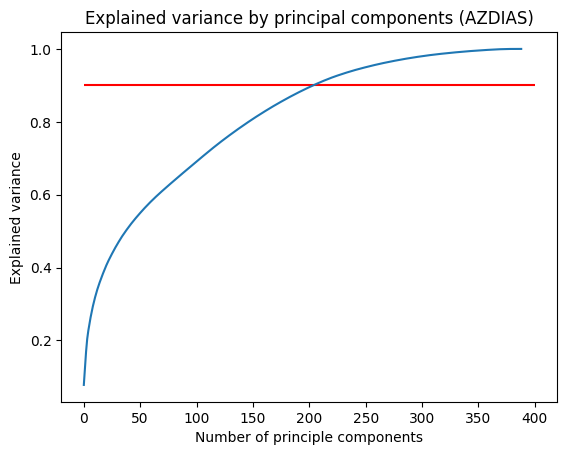

In [23]:
# plot explained variance on AZDIAS

pca = PCA()
azdias_pca = pca.fit_transform(azdias_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance by principal components (AZDIAS)')
plt.xlabel('Number of principle components')
plt.ylabel('Explained variance')
plt.hlines(xmin=0, xmax=400, y=.9, color='red')

plt.show()

In [24]:
# perform eigendecomposition on covariance matrix

cov_mat_cus = np.cov(customers_scaled.T)

eig_vals_cus, eig_vecs_cus = np.linalg.eig(cov_mat_cus)

print('Eigenvectors \n%s' %eig_vecs_cus)
print('Eigenvalues \n%s' %eig_vals_cus)

Eigenvectors 
[[-7.84934143e-04 -2.57927140e-04 -3.29362969e-04 ... -1.02113367e-05
   2.43280157e-04 -1.46395500e-04]
 [-9.45305939e-03 -3.38827968e-02  2.19412642e-02 ...  2.25820289e-03
  -2.07663843e-03  9.79699461e-03]
 [ 7.54991585e-03 -8.46067804e-02  4.13281788e-02 ... -1.52158731e-02
   1.10089524e-02 -4.16599618e-03]
 ...
 [ 5.68761990e-03 -3.51688447e-02  1.16775897e-02 ...  1.94337049e-02
   1.43899837e-02  2.69208751e-03]
 [-9.31798152e-04 -2.58907691e-02  7.35473589e-02 ... -8.16221281e-02
   1.03589607e-01 -5.03348311e-02]
 [-1.35398681e-01 -4.61610731e-02  1.66706172e-02 ...  5.30755065e-02
  -6.36383235e-02  4.59839835e-03]]
Eigenvalues 
[ 2.97083837e+01  2.25748852e+01  1.76610239e+01  1.10623794e+01
  7.66788591e+00  6.87336259e+00  6.17784202e+00  5.44421456e+00
  5.29110289e+00  4.75884411e+00  4.56538970e+00  4.33559620e+00
  4.09122035e+00  3.70820730e+00  3.61681062e+00  3.48287445e+00
  3.41926579e+00  3.20305923e+00  3.03095641e+00  3.00182908e+00
  2.87461319

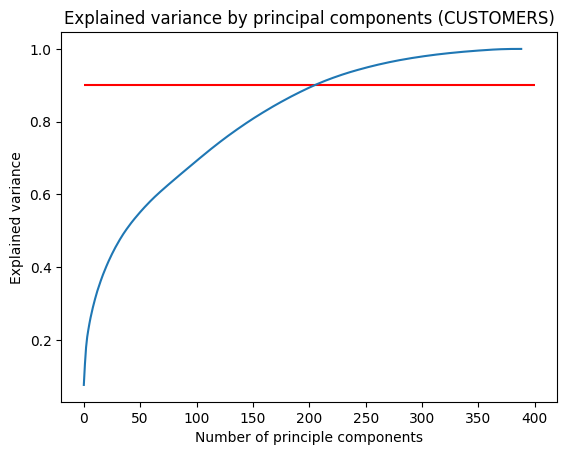

In [25]:
# plot explained variance on CUSTOMERS

pca = PCA()
customers_pca = pca.fit_transform(customers_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Explained variance by principal components (CUSTOMERS)')
plt.xlabel('Number of principle components')
plt.ylabel('Explained variance')
plt.hlines(xmin=0, xmax=400, y=.9, color='red')

plt.show()

The two plots above display cumulative explained data variance by principle components. 

We want to keep a small number of features while retaining high explained data variance. To decide how many top components to include, it's helpful to look at how much data variance the components capture. 

The red line shows the 90 % limit. Round about 210 features can explain 90% data variance. So I decided to keep 210 features.

In [26]:
def reduce_dimension(df, n): 
    
    pca = PCA(n_components=n)
    
    df = pca.fit_transform(df)
    df = pd.DataFrame(df)
    
    print('Explained data variance by top ' + str(n) + ' principal components is equal to ' 
          + str(pca.explained_variance_ratio_.sum())) 
    
    return pca, df

In [27]:
pca_azdias, azdias_pca = reduce_dimension(azdias_scaled, 210)

Explained data variance by top 210 principal components is equal to 0.9063579240998414


In [28]:
pca_customers, customers_pca = reduce_dimension(customers_scaled, 210)

Explained data variance by top 210 principal components is equal to 0.9044764038785523


In [29]:
azdias_pca.shape

(737287, 210)

In [30]:
customers_pca.shape

(191652, 210)

### 2. K-Means Clustering

After reducing the dimensions I will use kmeans clustering to compare segments of azdias and customers. With the help of the elbow graph I decided which number I clusters to use.

In [31]:
def apply_kmeans(data, n_clusters):

    """
    Calculate the average within-cluster distance given a number of cluster
    """
    
    kmeans = KMeans(n_clusters=n_clusters)
    
    model = kmeans.fit(data)
    
    return abs(model.score(data))

In [32]:
%%time
within_cluster_distances =[]
for n_cluster in range(2, 21):
     within_cluster_distances.append(apply_kmeans(azdias_pca.sample(20000), n_cluster))

CPU times: user 8min 49s, sys: 1min 16s, total: 10min 6s
Wall time: 1min 23s


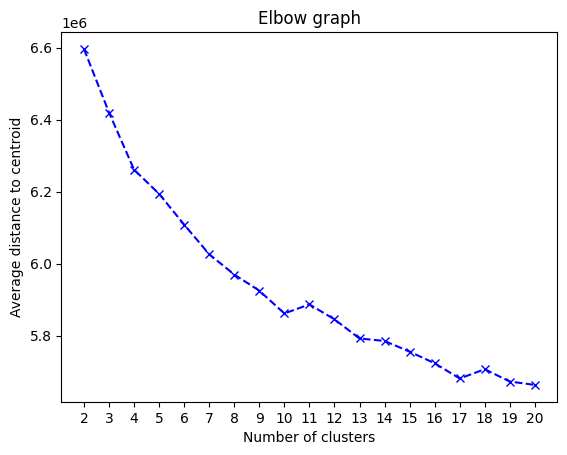

In [33]:
clusters = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
plt.plot(clusters, within_cluster_distances, \
        linestyle= "--",marker = "x", color="blue")
plt.xticks(ticks=clusters)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance to centroid')
plt.title('Elbow graph')

plt.show()

- The elbow graph shows "the first elbow" at 10 clusters. 14 Clusters could be a good alternative too, baed on the graph, but I decided to go with 10 clusters, because 10 segments are more handy than 14.

In [34]:
#set clusters to n = 10
n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters)

In [35]:
azdias_clusters = kmeans.fit_predict(azdias_pca)

In [36]:
azdias_clusters

array([5, 5, 1, ..., 5, 8, 4], dtype=int32)

In [37]:
customers_clusters = kmeans.fit_predict(customers_pca)


In [38]:
customers_clusters

array([2, 2, 9, ..., 2, 0, 8], dtype=int32)

### 3. Visualize Clusters differences between azdias and customers

In the next step I visualized the different segments to see the differences between azdias and customers.

In [39]:
cluster_info = pd.DataFrame([])

cluster_info["Population"] = pd.Series(azdias_clusters).value_counts().sort_index()
cluster_info["Customer"] = pd.Series(customers_clusters).value_counts().sort_index()
cluster_info.reset_index(inplace=True)
cluster_info.rename(columns={"index":"Cluster"}, inplace=True)
cluster_info

,Cluster,Population,Customer
0,0,57811,16963
1,1,96862,10872
2,2,47332,29571
3,3,93487,46907
4,4,92300,5983
5,5,102700,15420
6,6,67903,10107
7,7,48806,20638
8,8,75343,17190
9,9,54743,18001


In [40]:
cluster_info['Population %'] = (cluster_info['Population'] / (cluster_info['Population'].sum()) * 100).round(2)
cluster_info['Customer base %'] = (cluster_info['Customer'] / (cluster_info['Customer'].sum()) * 100).round(2)
cluster_info

,Cluster,Population,Customer,Population %,Customer base %
0,0,57811,16963,7.84,8.85
1,1,96862,10872,13.14,5.67
2,2,47332,29571,6.42,15.43
3,3,93487,46907,12.68,24.48
4,4,92300,5983,12.52,3.12
5,5,102700,15420,13.93,8.05
6,6,67903,10107,9.21,5.27
7,7,48806,20638,6.62,10.77
8,8,75343,17190,10.22,8.97
9,9,54743,18001,7.42,9.39


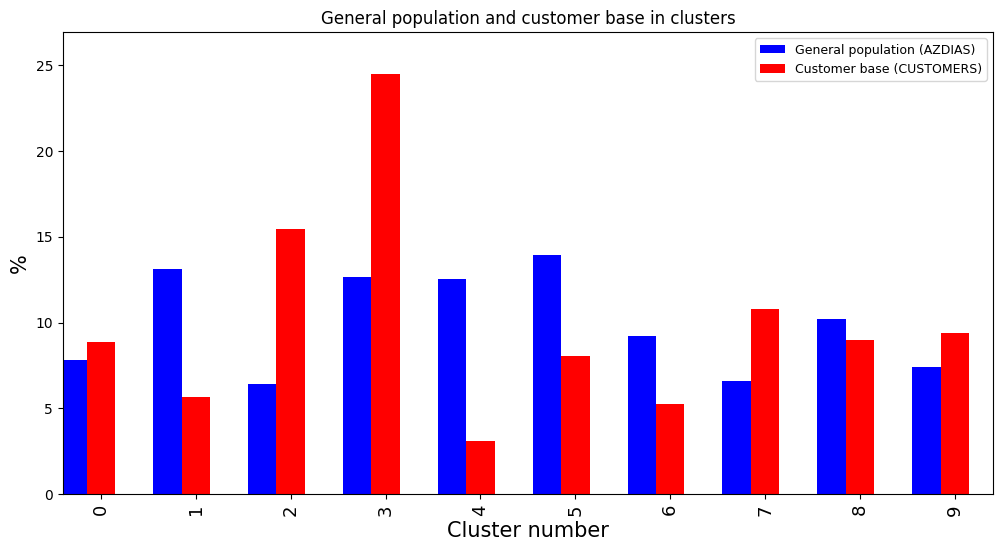

In [41]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(111)

ax = cluster_info['Population %'].plot(x=cluster_info['Cluster'], \
                                                  width=-0.3, align='edge', \
                                                  color='blue', kind='bar', position=0)
ax = cluster_info['Customer base %'].plot(kind='bar', color='red', width = 0.3, align='edge', position=1)

ax.set_xlabel('Cluster number', fontsize=15) 
ax.set_ylabel('%', fontsize=15)

ax.xaxis.set(ticklabels=range(10))
ax.tick_params(axis = 'x', which = 'major', labelsize = 13)
ax.margins(x=0.5,y=0.1)

plt.legend(('General population (AZDIAS)', 'Customer base (CUSTOMERS)'), fontsize=9)
plt.title(('General population and customer base in clusters'))

plt.show()

- The plot shows that some clusters are overrepresented by customers (0,1,5,7) whereas others don't. This gives us an idea of better targetting future customers.

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [42]:
#load data
mailout_train = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3553: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [43]:
mailout_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [44]:
mailout_train.shape

(42962, 367)

### 1. Balance train data

In [45]:
#take a look at target value (RESPONSE)
mailout_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [46]:
#split response values
c_1 = mailout_train[mailout_train['RESPONSE']==1] 
c_0 = mailout_train[mailout_train['RESPONSE']==0]

In [47]:
#balance response values
c_1_balanced = resample(c_1, replace=True, n_samples=mailout_train['RESPONSE'].value_counts()[0], random_state=1)

In [48]:
train_balanced = pd.concat([c_0, c_1_balanced ])

In [49]:
train_balanced['RESPONSE'].value_counts()

0    42430
1    42430
Name: RESPONSE, dtype: int64

### 2. Clean train data

In [50]:
# take the response column to be labels
labels = train_balanced['RESPONSE']

# drop the response column
train_balanced.drop(labels=['RESPONSE'], axis=1, inplace=True)

In [51]:
# drop the LNR column
train_balanced.drop(['LNR'], axis=1, inplace=True)

In [52]:
#slightly modify cleaning function: drop 'D19_LETZTER_KAUF_BRANCHE'
#
def clean_train_data(df, attributes_values, columns_to_drop):
    """
    Clean and prerpocess a dataframe
    - convert missing and unknown values to nan values
    - drop columns (features) with high %nan vlaues
    - drop rows with high %nan vlaues
    - re-encode categorical and mixed features
    - impute missing values
    
    INPUT
    - df (DataFrame): the DataFrame to be cleaned and preprocessed
    - attributes_values (DataFrame): the DataFrame to find unknown values for each feature
    - columns_to_drop (list): list of features to be droped due to high %nan values
    - nan_threshold (int): threshold to use for dropping rows having high %nan values
    
    OUTPUT
    - df_imputed (DataFrame): a cleaned and preprocessed DataFrame with nan values imputed
    """
    # convert missing and unknown values to nan values
    attributes_values = attributes_values[attributes_values.columns[1:]]
    attributes_values = attributes_values[attributes_values['Attribute'].notnull()]
    unknown = attributes_values[attributes_values['Meaning'].isin(['unknown', 'unknown / no main age detectable'])]

    for column in df.columns:
        if df[column].dtype == np.int64:
            df[column] = df[column].astype(np.float64)
        if column not in set(unknown['Attribute']):
            continue
        
        unknown_value = unknown.loc[unknown['Attribute'] == column].Value.item()
        unknown_value = set(float(x) for x in unknown_value.split(', ')) if type(unknown_value) is str else set([float(unknown_value)])
        df[column] = df[column].mask(df[column].isin(unknown_value), other=np.nan)
    
    
    
    # drop columns (features) with %nan values over a threshold
    df.drop(labels=columns_to_drop, axis=1, inplace=True)

    # drop rows with %missing values over a threshold
    #missing_row = azdias.isnull().sum(axis=1)/azdias.shape[1]*100
    #df = df[missing_row <= nan_threshold]

    # RE-ENCODE FEATURES #
    
    #drop database timestamp and D19_LETZTER_KAUF_BRANCHE
    df.drop(['D19_LETZTER_KAUF_BRANCHE','EINGEFUEGT_AM'], axis=1, inplace=True)
    
    # change 'X'  and 'xx' to nan
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.nan)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.nan)
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('XX', np.nan)

    # change str to float
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    
    #import sklearn one hot encoder
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder()
    
    #create columns to encode list
    columns_to_encode = df.columns[df.dtypes == "object"].tolist()
    
    #create df with features to encode
    encode = df[columns_to_encode]
    encode = encode.fillna('0')
    
    #encode features with one hot encoder
    feature_array = ohe.fit_transform(encode).toarray()
    feature_labels = ohe.categories_
    feature_labels = np.hstack(feature_labels)
    
    #add labels to feature array and convert to dataframe
    features = pd.DataFrame(feature_array, columns=feature_labels)
    #drop nan column
    features.drop(labels='0', axis=1, inplace=True)
    
    #drop columns to encode from azdias
    df = df.drop(labels=columns_to_encode,  axis=1)
    
    #add one hot encoded features to azdias
    df = df.reset_index().drop(labels='index',  axis=1)
    df = pd.concat([df, features], axis=1, ignore_index=False)
    
    return df

In [53]:
attributes_values = pd.read_excel('DIAS Attributes - Values 2017.xlsx', header=1)

In [54]:
#drop columns with missing values over 20%
percent_missing_col_train = train_balanced.isnull().mean() * 100
columns_to_drop_train = percent_missing_col_train [percent_missing_col_train  > 20].index

In [55]:
train = clean_train_data(train_balanced, attributes_values, columns_to_drop_train)

In [56]:
train = impute_data(train)

NameError: name 'impute_data' is not defined

In [ ]:
print('TRAIN|Data shape (rows, cols): ', train.shape)
print()
train.head()

In [ ]:
train = scale_data(train)

In [ ]:
train.head()

Outcome: Fully preprocessed datadump for model training

### 3. Compare model performance

I decided to compare three different models performances based on the AUROC Score to decide which one I will use to predict customers on testing data. For that I choose the logistic regression, gradient boosting and lightGBM. 

In [ ]:
def train_classifier(classifier, param_grid, X=train, y=labels):
    """
    Fit a classifier using GridSearchCV, compute ROC AUC metric
    
    INPUT:
    - classifier (classifier): classifier to fit 
    - param_grid (dict): parameters of the classifier used with GridSearchCV
    - X (DataFrame): features of the training dataframe
    - y (DataFrame): labels of the training dataframe
            
    OUTPUT:
    - classifier: fitted classifier
    - AUROC score and elapsed time
    """
    start = time.time()
    
    grid = GridSearchCV(estimator=classifier, param_grid=param_grid, scoring='roc_auc', cv=5)
    grid.fit(X, y)
    
    end = time.time()
    print('Time taken:', end-start)

    print('AUROC score:', grid.best_score_)
    
    return grid.best_estimator_

#### i. Logistic Regression

In [ ]:
logistic_reg = LogisticRegression(random_state=10)

In [ ]:
print(train_classifier(logistic_reg, {}))

#### ii. Gradient Boosting

In [ ]:
gradient_boosting_clf = GradientBoostingClassifier(random_state=10)

In [ ]:
print(train_classifier(gradient_boosting_clf, {}))

#### iii. LightGBM

In [ ]:
lightgbm_clf = LGBMClassifier(random_state=10)

In [ ]:
print(train_classifier(lightgbm_clf, {}))

- From the three models lightGBM has the best performance on the auroc score, but the score of .98 seems to good to be true. That could indicate some problems with overfitting. So I choosed gradient boosting as the way to go for tuning and prediction, even if it takes much more technical ressources.

### 4. Select and tune model

In [ ]:
gbc = GradientBoostingClassifier(random_state=10)

gbc_param_grid = {'loss': ['deviance'],
              'max_depth': [3],
              'learning_rate': [0.1],
              'n_estimators': [100],
              'random_state': [10]
             }

gbc_best_estimator = train_classifier(gbc, gbc_param_grid)

### 5. Load test data

After selecting and tuning the model I will use the trained model to predict customers on the test data.

In [ ]:
mailout_test = pd.read_csv('arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [ ]:
print('TEST|Data shape (rows, cols): ', mailout_test.shape)
print()
mailout_test.head()

In [ ]:
# Copy LNR column
test_LNR = mailout_test['LNR']

mailout_test.drop(['LNR'], axis=1, inplace=True)

In [ ]:
test = clean_train_data(mailout_test, attributes_values, columns_to_drop_train)

In [ ]:
test = impute_data(test)

In [ ]:
test = scale_data(test)

In [ ]:
print('TEST|Data shape (rows, cols): ', test.shape)
print()
test.head()

In [ ]:
prediction = gbc_best_estimator.predict_proba(test)

In [ ]:
prediction = pd.DataFrame({'LNR':test_LNR.astype(np.int32), 'RESPONSE':prediction[:, 1]})

In [ ]:
prediction.head()

In [ ]:
print('Result: ' + str(prediction[prediction['RESPONSE']>0.5].shape[0]) + ' of all ' +str(prediction['RESPONSE'].shape[0]) +' individuals are likely to become a customer of the mail order company. These are round about 21% of all test individuals.')